In [1]:
import requests
import time

url = 'http://ws.clarin-pl.eu/nlprest2/base'

def process(text):
    file_id = requests.post(url + '/upload/', data=text.encode('utf-8'), headers={'Content-Type': 'binary/octet-stream'}).text
    task_id = requests.post(url + '/startTask/', 
                            json={'lpmn': 'any2txt|wcrft2|liner2({"model":"n82"})', 'file': file_id, 'user': ''},
                            headers={'Content-Type': 'application/json'}).text
    response = requests.get(url + '/getStatus/' + task_id).json()
    while response["status"] == "QUEUE" or response["status"] == "PROCESSING" :
        time.sleep(0.5)
        response = requests.get(url + '/getStatus/' + task_id).json()
        
    if response["status"]=="ERROR":
            print("Error " + data["value"]);
            return None
    
    if response['status'] == 'DONE' and response['value']:
        return requests.get(url + '/download' + response['value'][0]['fileID']).text

In [2]:
# put absolute path here
DATA_DIR = r"C:\Users\Joanna\NLP_homeworks\json"

In [3]:
# making usage of my helper .py file in jupyter environment on any computer
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from file_utils import *
data_manager = DataManager(DATA_DIR)

In [4]:
# Actual homework starts here
import re
generator = data_manager.judgments_generator(year=2009)

In [5]:
def remove_html(x):
    return re.sub("<[^>]*>", "", x)

def remove_linebreaks(x):
    return re.sub("-\n", "", x)

In [6]:
# If not already processed
# counter = 0
# while counter < 100:
#     try:
#         content = generator.__next__()
#         text = remove_linebreaks(remove_html(content["textContent"]))
#         processed = process(text)
#         if processed:
#             with open("%d.txt" % counter, "w", encoding='utf-8') as text_file:
#                 text_file.write(processed)
#                 print(processed[:200])
#             counter += 1
#     except StopIteration:
#         break

In [7]:
import xml.etree.ElementTree
from collections import defaultdict
from itertools import groupby

parsed_units = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for judgment_num in range(0, 100):
    with open("./parsed/%d.txt" % judgment_num, 'r', encoding='utf-8') as file:
        for sentence in xml.etree.ElementTree.fromstring(file.read()).iter("sentence"):
            tokens = defaultdict(str)
            for token in sentence.iter("tok"):
                for annotation in token.iter("ann"):
                    if annotation.text != '0':
                        tokens[annotation.text, annotation.attrib["chan"]] += ' ' + token.find('lex/base').text
            for key, phrase in tokens.items():
                parsed_units["_".join(key[1].split('_')[:2])][key[1]][phrase] += 1
print(parsed_units)

defaultdict(<function <lambda> at 0x0000014BC5CF8BF8>, {'nam_org': defaultdict(<function <lambda>.<locals>.<lambda> at 0x0000014BC5D08730>, {'nam_org_institution': defaultdict(<class 'int'>, {' imienie rzeczpospolita polski dzień': 16, ' sąd najwyższy': 274, ' zakład ubezpieczenie społeczny oddział': 2, ' izba praca': 3, ' ubezpieczenie społeczny i sprawa publiczny': 3, ' sąd apelacyjny': 222, ' sąd okręgowy - sąd praca i ubezpieczenie społeczny': 12, ' zakład ubezpieczenie społeczny': 10, ' fundusz ubezpieczenie społeczny': 14, ' sąd okręgowy – sąd praca i ubezpieczenie społeczny': 1, ' zakład transformator radiowy': 1, ' sąd okręgowy': 266, ' sąd apelacyjny – sąd praca i ubezpieczenie społeczny': 1, ' krajowy izba odwoławczy': 79, ' urząd zamówienie publiczny': 81, ' Mazowiecki zarząd droga wojewódzki': 2, ' zarząd droga wojewódzki': 11, ' prezes urząd zamówienie publiczny': 42, ' sąd apelacyjny w Katowice': 1, ' skarb państwo': 109, ' uzasadnienie sąd okręgowy': 1, ' odwoławczy komi

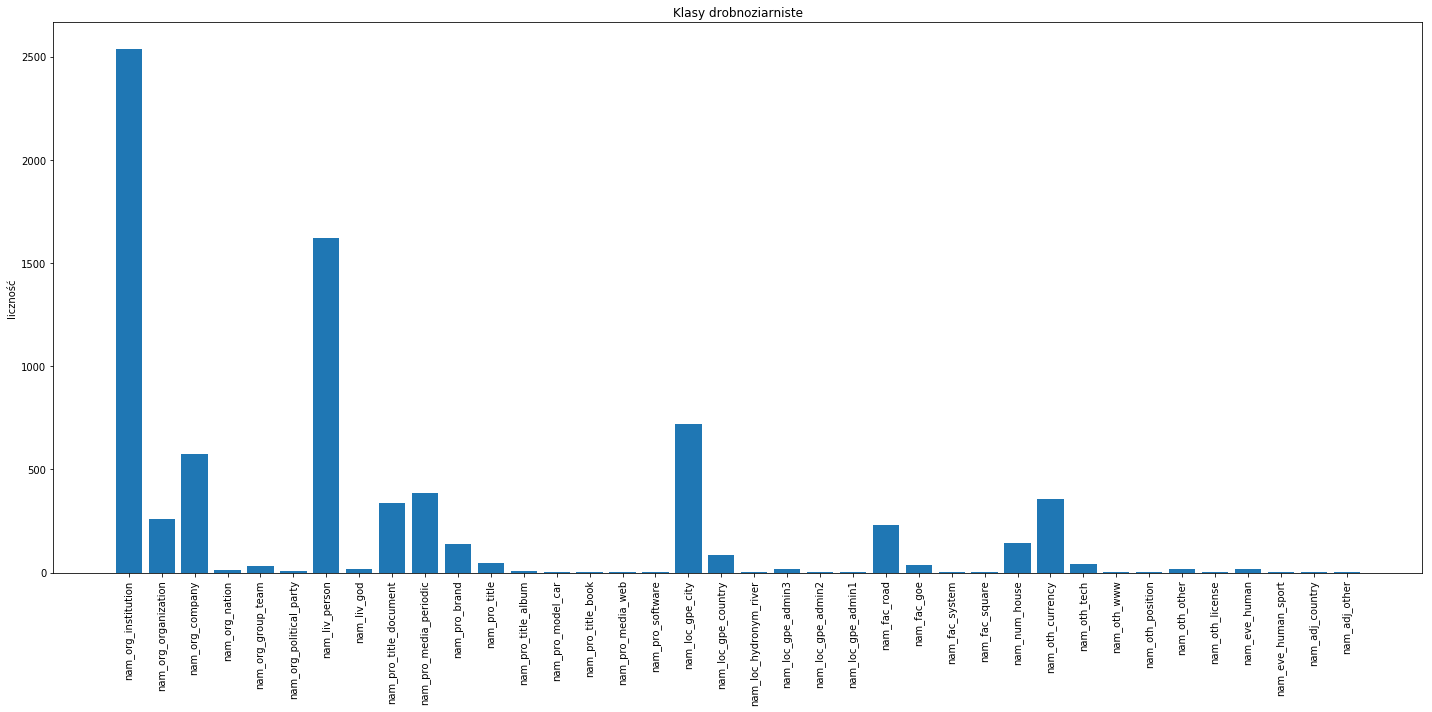

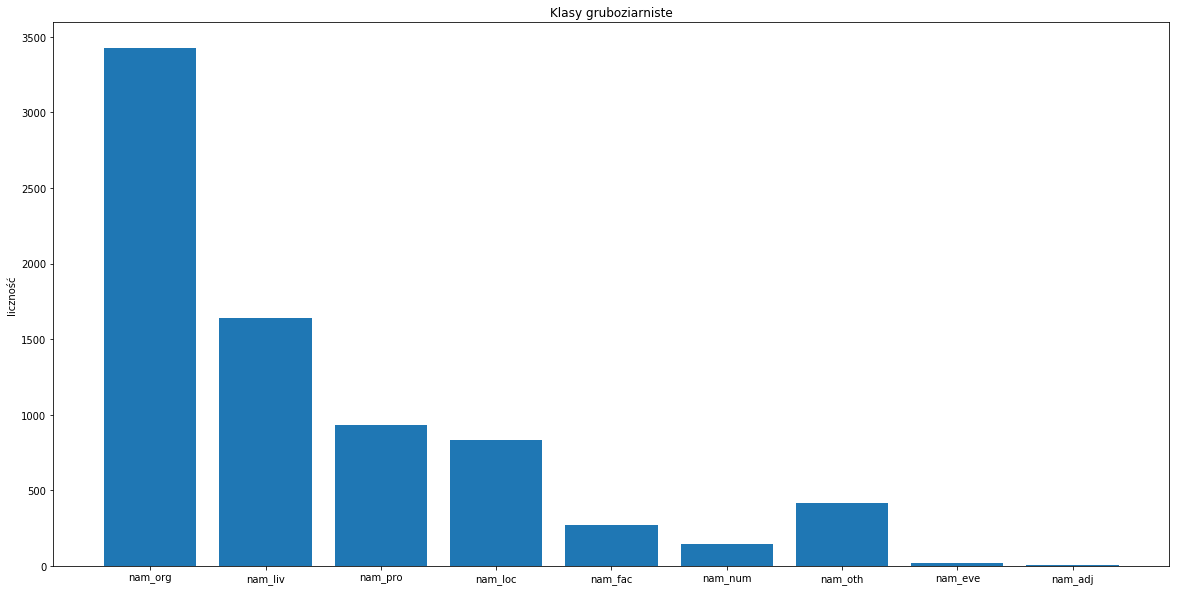

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Przedstaw liczność rozpoznanych klas w postaci dwóch wykresów:
# na pierwszy wykresie przedstaw drobnoziarnistą klasyfikację wyrażeń
# tzn. uwzględniając klasy takie jak nam_fac_bridge, nam_liv_animal, nam_loc_gpe, itd.,
labels = []
counts = []
for detailed_dict in parsed_units.values():
    for cat_name, words_dict in detailed_dict.items():
        counts.append(sum(words_dict.values()))
        labels.append(cat_name)
plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(counts))], counts)
plt.xticks([i for i in range(len(counts))], labels, rotation='vertical')
plt.ylabel('liczność')
plt.title('Klasy drobnoziarniste')
plt.tight_layout()
plt.show() 

# na drugim wykresie przedstaw zgrubną klasyfikację wyrażeń. 
# tzn. uwzględniając klasy takie jak nam_adj, nam_eve, nam_fac, nam_liv, itd.
labels = []
counts = []
for cat_name, cat_dict in parsed_units.items():
    counts.append(sum([sum(counts.values()) for counts in cat_dict.values()]))
    labels.append(cat_name)

plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(counts))], counts)
plt.xticks([i for i in range(len(counts))], labels)
plt.ylabel('liczność')
plt.title('Klasy gruboziarniste')
plt.show() 

In [9]:
# Przedstaw 100 najczęściej rozpoznanych wyrażeń, wraz z podaniem liczby ich wystąpień oraz kategorii semantycznej 
# (tzn. niskopoziomowej (drobnoziarnistej) klasy przypisanej przez NER).
import operator
candidates = []
for subcategories in parsed_units.values():
    for subcategory, word_counts in subcategories.items():
        sorted_words = sorted(word_counts.items(), key=operator.itemgetter(1), reverse=True)[:100]
        candidates.extend([(element[0], element[1], subcategory) for element in sorted_words])
for element in sorted(candidates, key=lambda x: x[1], reverse=True)[:100]:
    print(element)

(' zamawiać', 359, 'nam_liv_person')
(' złoty', 343, 'nam_oth_currency')
(' trybunał konstytucyjny', 315, 'nam_org_institution')
(' sąd najwyższy', 274, 'nam_org_institution')
(' sąd okręgowy', 266, 'nam_org_institution')
(' dziennik . u .', 251, 'nam_pro_media_periodic')
(' sąd apelacyjny', 222, 'nam_org_institution')
(' Warszawa', 197, 'nam_loc_gpe_city')
(' odwoływać', 123, 'nam_liv_person')
(' skarb państwo', 109, 'nam_org_institution')
(' TK', 95, 'nam_org_institution')
(' sąd rejonowy', 90, 'nam_org_institution')
(' prawo zamówienie publiczny', 85, 'nam_pro_title_document')
(' urząd zamówienie publiczny', 81, 'nam_org_institution')
(' krajowy izba odwoławczy', 79, 'nam_org_institution')
(' najwyższy', 78, 'nam_liv_person')
(' wykonawca', 63, 'nam_liv_person')
(' Dzieje_(Apostolskie) . u .', 60, 'nam_pro_media_periodic')
(' Wrocław', 53, 'nam_loc_gpe_city')
(' AnsaldoBreda sekunda', 47, 'nam_pro_brand')
(' Newag sekunda', 45, 'nam_pro_brand')
(' Katowice', 43, 'nam_loc_gpe_city')


In [10]:
# Przedstaw 10 najczęstszych wyrażeń, dla każdej wysokopoziomowej (zgrubnej) klasy wyrażeń.
for cat_name, subcategories in parsed_units.items():
    candidates = []
    for subcategory, word_counts in subcategories.items():
        sorted_words = sorted(word_counts.items(), key=operator.itemgetter(1), reverse=True)[:10]
        candidates.extend(sorted_words)
    candidates.sort(key=lambda x: x[1], reverse=True)
    print(cat_name.upper())
    for element in sorted(candidates, key=lambda x: x[1], reverse=True)[:10]:
        print(element)
    print('\n')

NAM_ORG
(' trybunał konstytucyjny', 315)
(' sąd najwyższy', 274)
(' sąd okręgowy', 266)
(' sąd apelacyjny', 222)
(' skarb państwo', 109)
(' TK', 95)
(' sąd rejonowy', 90)
(' urząd zamówienie publiczny', 81)
(' krajowy izba odwoławczy', 79)
(' prezes urząd zamówienie publiczny', 42)


NAM_LIV
(' zamawiać', 359)
(' odwoływać', 123)
(' najwyższy', 78)
(' wykonawca', 63)
(' protestujący', 28)
(' operator', 23)
(' kart nauczyciel', 22)
(' Bruno sekunda . T', 20)
(' Barbar Boczulak', 16)
(' Andrzej F', 14)


NAM_PRO
(' dziennik . u .', 251)
(' prawo zamówienie publiczny', 85)
(' Dzieje_(Apostolskie) . u .', 60)
(' AnsaldoBreda sekunda', 47)
(' Newag sekunda', 45)
(' kodeks cywilny', 22)
(' konstytucja rzeczpospolita polski', 21)
(' kodeks postępowanie cywilny', 20)
(' BOCZULAK', 17)
(' wymaganie ogólny', 14)


NAM_LOC
(' Warszawa', 197)
(' Wrocław', 53)
(' Katowice', 43)
(' Polska', 31)
(' Poznań', 24)
(' izba', 21)
(' Białystok', 21)
(' Lublin', 19)
(' rzeczpospolita polski', 13)
(' Hiszpan